# (GMM) Gaussian Mixture Models Clustering



## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from sklearn.datasets import make_blobs, load_iris, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seed and plotting style
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Generate Synthetic Data

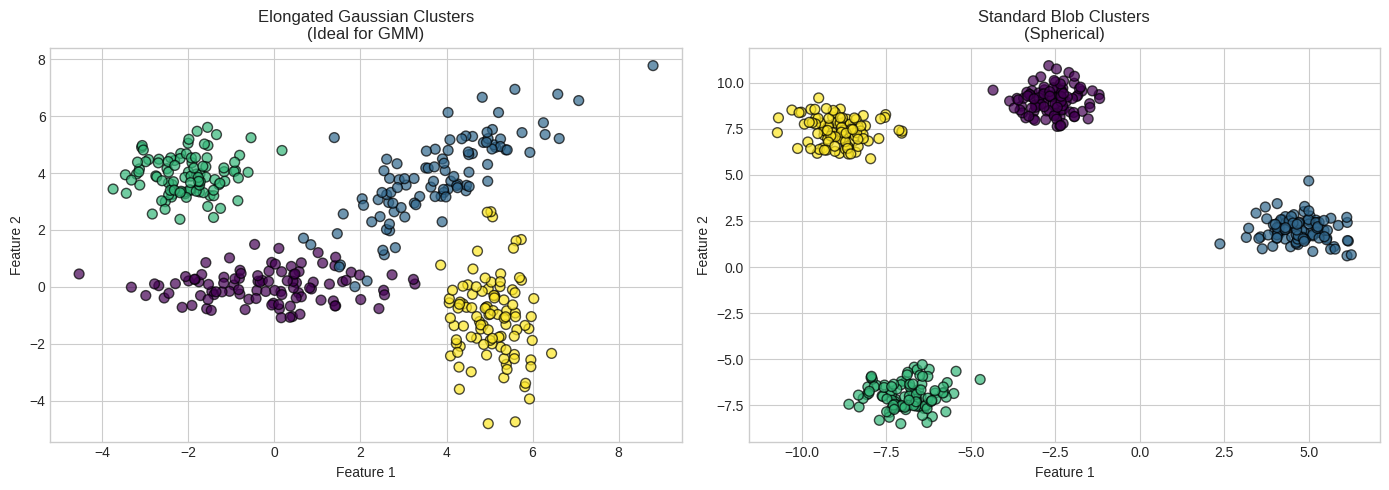

Elongated clusters shape: (400, 2)
Blob clusters shape: (400, 2)


In [2]:
# Generate elongated clusters (where GMM excels)
np.random.seed(42)

# Create elongated Gaussian clusters with different covariances
n_samples = 400

# Cluster 1: Elongated horizontally
cov1 = [[3, 0], [0, 0.3]]
cluster1 = np.random.multivariate_normal([0, 0], cov1, n_samples // 4)

# Cluster 2: Elongated diagonally
cov2 = [[2, 1.5], [1.5, 2]]
cluster2 = np.random.multivariate_normal([4, 4], cov2, n_samples // 4)

# Cluster 3: Nearly spherical
cov3 = [[0.5, 0], [0, 0.5]]
cluster3 = np.random.multivariate_normal([-2, 4], cov3, n_samples // 4)

# Cluster 4: Elongated vertically
cov4 = [[0.3, 0], [0, 2]]
cluster4 = np.random.multivariate_normal([5, -1], cov4, n_samples // 4)

# Combine all clusters
X_gmm = np.vstack([cluster1, cluster2, cluster3, cluster4])
y_true_gmm = np.array([0] * (n_samples // 4) + [1] * (n_samples // 4) +
                       [2] * (n_samples // 4) + [3] * (n_samples // 4))

# Also generate standard blob data for comparison
X_blobs, y_blobs = make_blobs(n_samples=400, centers=4, cluster_std=0.7, random_state=42)

# Visualize the data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_gmm[:, 0], X_gmm[:, 1], c=y_true_gmm, cmap='viridis',
                alpha=0.7, edgecolors='k', s=50)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Elongated Gaussian Clusters\n(Ideal for GMM)')

axes[1].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='viridis',
                alpha=0.7, edgecolors='k', s=50)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Standard Blob Clusters\n(Spherical)')

plt.tight_layout()
plt.show()

print(f"Elongated clusters shape: {X_gmm.shape}")
print(f"Blob clusters shape: {X_blobs.shape}")

## 3. Understanding GMM: Covariance Types

In [3]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    """Plot the GMM cluster assignments and covariance ellipses"""
    ax = ax or plt.gca()
    labels = gmm.fit_predict(X)

    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', alpha=0.7)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, alpha=0.7)

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax,
                    facecolor='none', edgecolor='red', linewidth=2)

TypeError: cannot unpack non-iterable numpy.float64 object

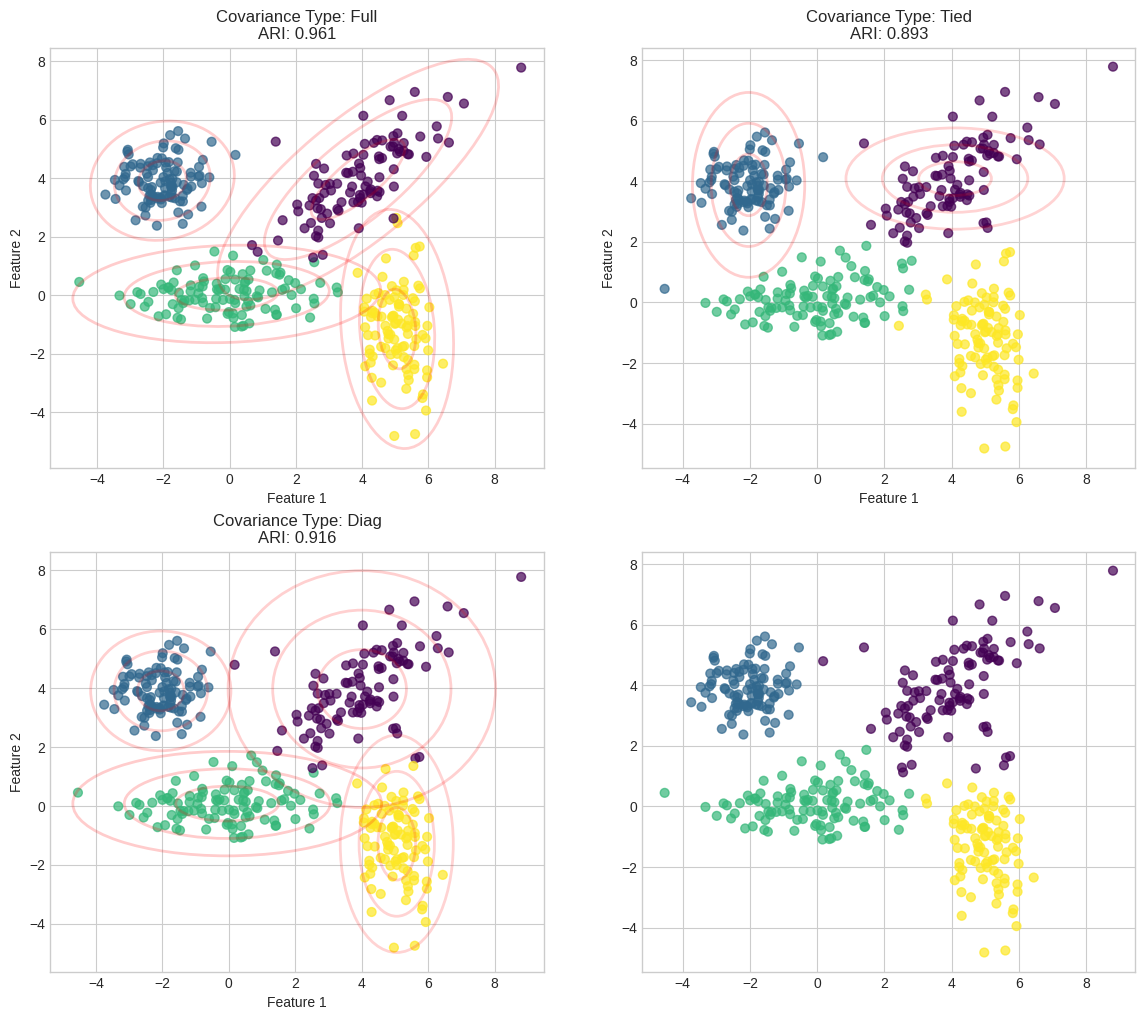

In [16]:
# Compare different covariance types
covariance_types = ['full', 'tied', 'diag', 'spherical']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, cov_type in enumerate(covariance_types):
    gmm = GaussianMixture(n_components=4, covariance_type=cov_type, random_state=42)
    labels = gmm.fit_predict(X_gmm)

    # Calculate ARI
    ari = adjusted_rand_score(y_true_gmm, labels)

    # Plot
    plot_gmm(gmm, X_gmm, ax=axes[idx])
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')
    axes[idx].set_title(f'Covariance Type: {cov_type.capitalize()}\nARI: {ari:.3f}')

plt.suptitle('GMM with Different Covariance Types on Elongated Clusters',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCovariance Type Descriptions:")
print("• Full: Each component has its own general covariance matrix")
print("• Tied: All components share the same general covariance matrix")
print("• Diag: Each component has its own diagonal covariance matrix")
print("• Spherical: Each component has its own single variance")

## 4. Soft Clustering: Probability Assignments

In [15]:
# Demonstrate soft clustering
gmm_full = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm_full.fit(X_gmm)

# Get probabilities for each cluster
probs = gmm_full.predict_proba(X_gmm)
labels = gmm_full.predict(X_gmm)

# Display probability distribution for some samples
print("Soft Clustering - Probability Assignments:")
print("="*60)
prob_df = pd.DataFrame(probs, columns=[f'Cluster {i}' for i in range(4)])
prob_df['Assigned Cluster'] = labels
prob_df['Max Probability'] = probs.max(axis=1)

print("\nSample of probability assignments (first 10 points):")
print(prob_df.head(10).to_string())

Soft Clustering - Probability Assignments:

Sample of probability assignments (first 10 points):
   Cluster 0     Cluster 1  Cluster 2     Cluster 3  Assigned Cluster  Max Probability
0   0.010415  2.442431e-12   0.989585  1.963462e-12                 2         0.989585
1   0.140119  1.972613e-09   0.859881  1.072877e-10                 2         0.859881
2   0.004356  7.943855e-10   0.995644  9.340147e-21                 2         0.995644
3   0.022134  2.668615e-16   0.976635  1.231353e-03                 2         0.976635
4   0.003381  1.494955e-07   0.996619  9.590109e-24                 2         0.996619
5   0.002528  1.167839e-09   0.997472  9.505123e-24                 2         0.997472
6   0.005264  9.966853e-15   0.994736  1.864311e-14                 2         0.994736
7   0.000018  3.473559e-08   0.999982  1.167847e-43                 2         0.999982
8   0.000387  5.852213e-07   0.999612  1.220411e-31                 2         0.999612
9   0.001245  1.542150e-10   0.99

NameError: name 'probs' is not defined

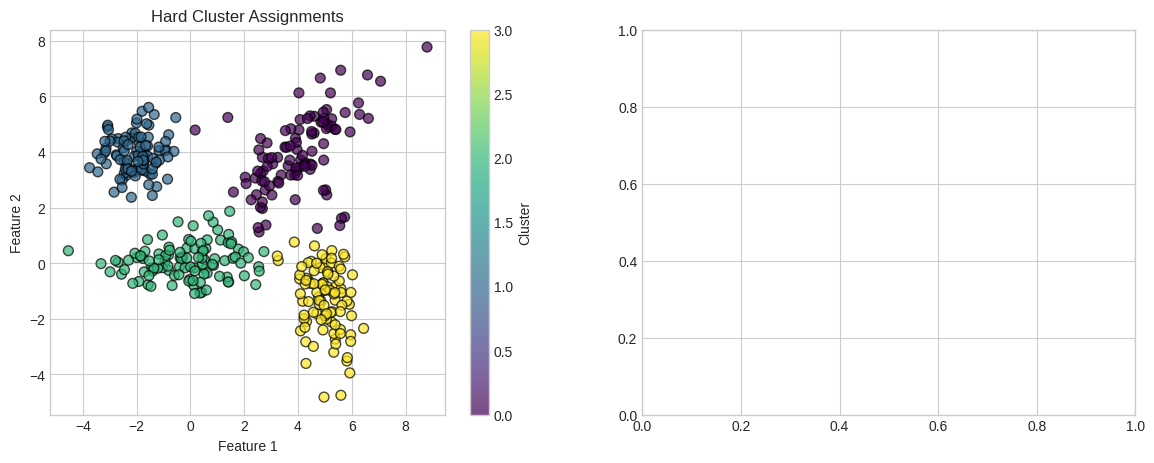

In [6]:
# Visualize uncertainty in cluster assignments
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Points colored by cluster
scatter1 = axes[0].scatter(X_gmm[:, 0], X_gmm[:, 1], c=labels, cmap='viridis',
                           alpha=0.7, edgecolors='k', s=50)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Hard Cluster Assignments')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Points sized/colored by uncertainty
uncertainty = 1 - probs.max(axis=1)  # Higher uncertainty = lower max probability
scatter2 = axes[1].scatter(X_gmm[:, 0], X_gmm[:, 1], c=uncertainty, cmap='Reds',
                           alpha=0.7, edgecolors='k', s=50 + 200 * uncertainty)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Cluster Assignment Uncertainty\n(Larger/Darker = More Uncertain)')
plt.colorbar(scatter2, ax=axes[1], label='Uncertainty')

plt.tight_layout()
plt.show()

# Statistics on uncertainty
print(f"\nUncertainty Statistics:")
print(f"  Mean uncertainty: {uncertainty.mean():.4f}")
print(f"  Max uncertainty: {uncertainty.max():.4f}")
print(f"  Points with >10% uncertainty: {(uncertainty > 0.1).sum()}")

## 5. Model Selection: BIC and AIC

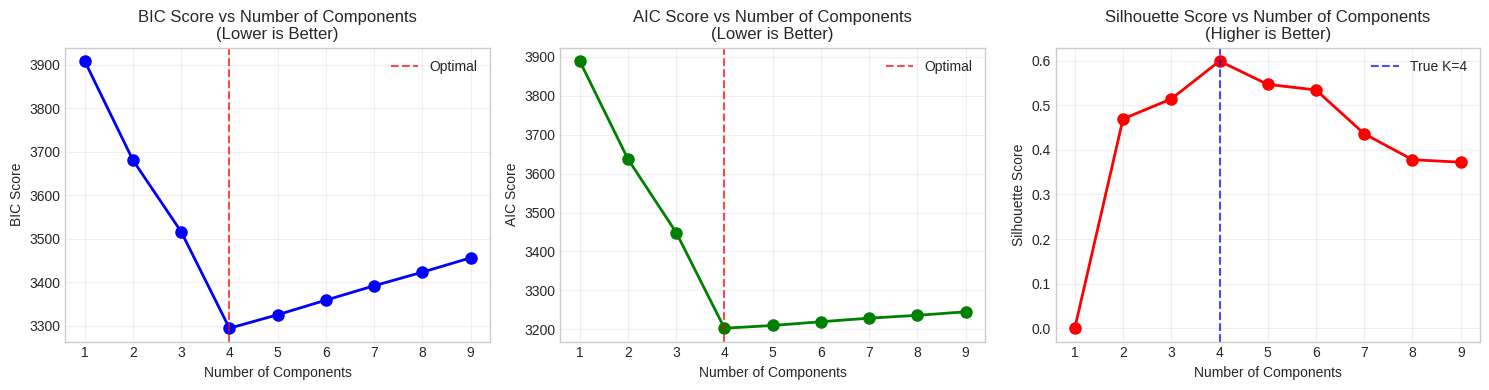


Optimal number of components:
  By BIC: 4
  By AIC: 4
  By Silhouette: 4


In [7]:
# Use BIC and AIC to determine optimal number of components
n_components_range = range(1, 10)

bic_scores = []
aic_scores = []
silhouette_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_gmm)
    bic_scores.append(gmm.bic(X_gmm))
    aic_scores.append(gmm.aic(X_gmm))

    if n > 1:
        labels = gmm.predict(X_gmm)
        silhouette_scores.append(silhouette_score(X_gmm, labels))
    else:
        silhouette_scores.append(0)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(n_components_range, bic_scores, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('BIC Score')
axes[0].set_title('BIC Score vs Number of Components\n(Lower is Better)')
axes[0].axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Optimal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(n_components_range, aic_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('AIC Score')
axes[1].set_title('AIC Score vs Number of Components\n(Lower is Better)')
axes[1].axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Optimal')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(n_components_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Components')
axes[2].set_ylabel('Silhouette Score')
axes[2].set_title('Silhouette Score vs Number of Components\n(Higher is Better)')
axes[2].axvline(x=4, color='blue', linestyle='--', alpha=0.7, label='True K=4')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal
optimal_bic = list(n_components_range)[np.argmin(bic_scores)]
optimal_aic = list(n_components_range)[np.argmin(aic_scores)]
optimal_sil = list(n_components_range)[np.argmax(silhouette_scores)]

print(f"\nOptimal number of components:")
print(f"  By BIC: {optimal_bic}")
print(f"  By AIC: {optimal_aic}")
print(f"  By Silhouette: {optimal_sil}")

## 6. GMM vs K-Means Comparison

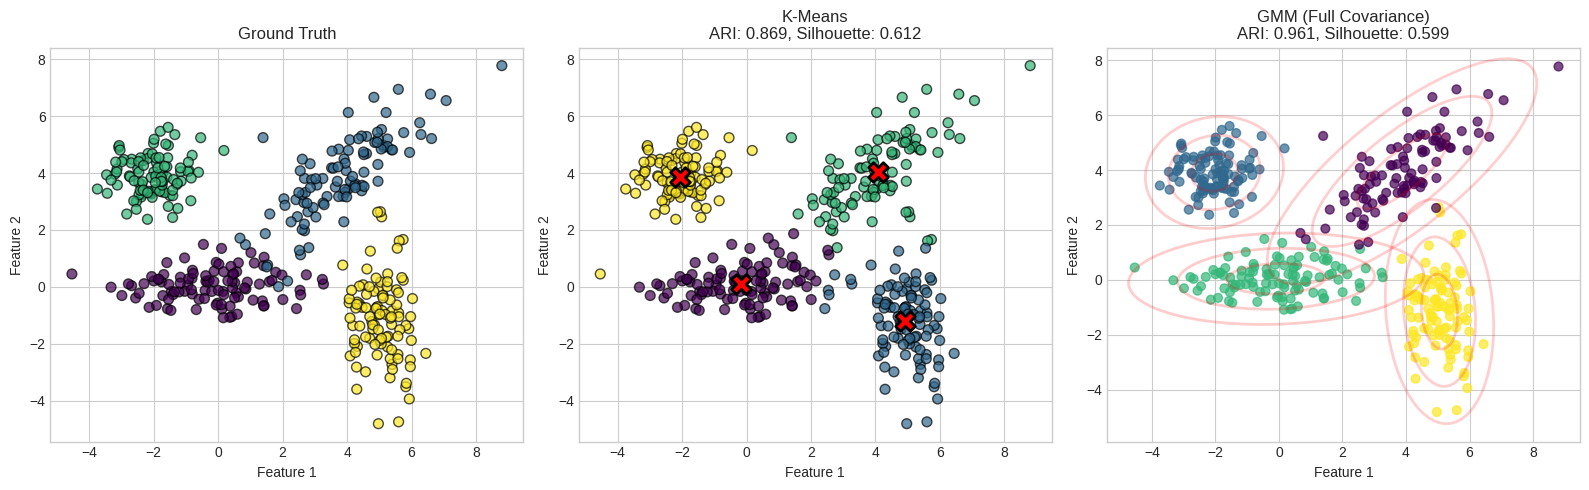


Comparison Summary:
  K-Means - ARI: 0.8686, Silhouette: 0.6122
  GMM     - ARI: 0.9608, Silhouette: 0.5991

GMM with full covariance handles elongated clusters better!


In [8]:
# Compare GMM and K-Means on elongated clusters
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Ground truth
axes[0].scatter(X_gmm[:, 0], X_gmm[:, 1], c=y_true_gmm, cmap='viridis',
                alpha=0.7, edgecolors='k', s=50)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Ground Truth')

# K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_gmm)
ari_km = adjusted_rand_score(y_true_gmm, labels_km)
sil_km = silhouette_score(X_gmm, labels_km)

axes[1].scatter(X_gmm[:, 0], X_gmm[:, 1], c=labels_km, cmap='viridis',
                alpha=0.7, edgecolors='k', s=50)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title(f'K-Means\nARI: {ari_km:.3f}, Silhouette: {sil_km:.3f}')

# GMM
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(X_gmm)
ari_gmm = adjusted_rand_score(y_true_gmm, labels_gmm)
sil_gmm = silhouette_score(X_gmm, labels_gmm)

plot_gmm(gmm, X_gmm, ax=axes[2])
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].set_title(f'GMM (Full Covariance)\nARI: {ari_gmm:.3f}, Silhouette: {sil_gmm:.3f}')

plt.tight_layout()
plt.show()

print("\nComparison Summary:")
print(f"  K-Means - ARI: {ari_km:.4f}, Silhouette: {sil_km:.4f}")
print(f"  GMM     - ARI: {ari_gmm:.4f}, Silhouette: {sil_gmm:.4f}")
print("\nGMM with full covariance handles elongated clusters better!")

## 7. Density Estimation with GMM

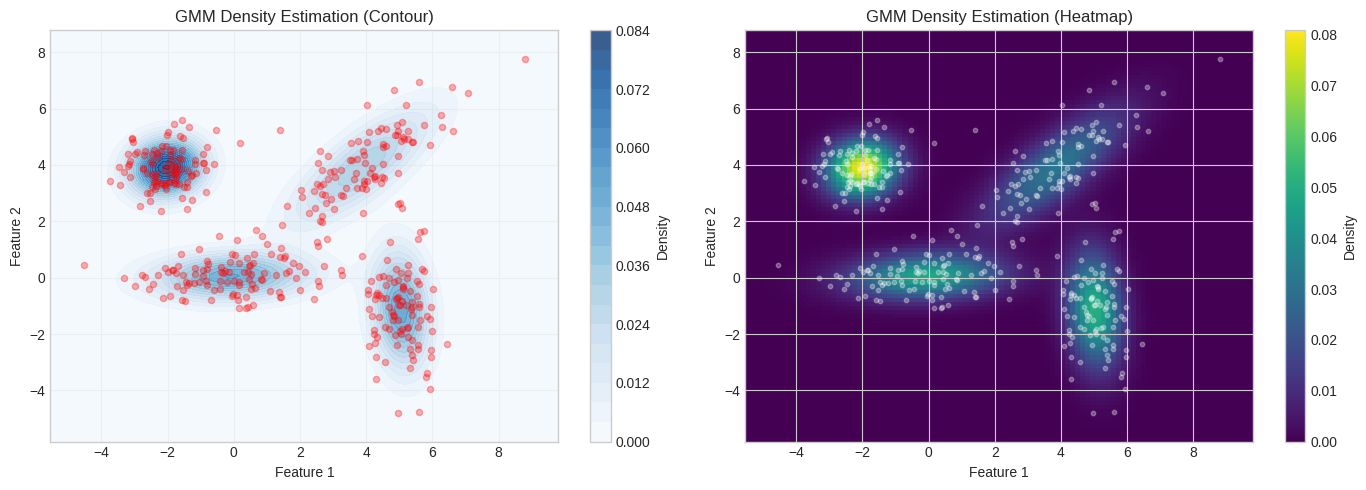

In [9]:
# GMM can also be used for density estimation
gmm_density = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm_density.fit(X_gmm)

# Create a grid for density visualization
x_min, x_max = X_gmm[:, 0].min() - 1, X_gmm[:, 0].max() + 1
y_min, y_max = X_gmm[:, 1].min() - 1, X_gmm[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Calculate log-likelihood (density) on the grid
log_density = gmm_density.score_samples(grid_points)
density = np.exp(log_density).reshape(xx.shape)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contour plot
cs = axes[0].contourf(xx, yy, density, levels=20, cmap='Blues', alpha=0.8)
axes[0].scatter(X_gmm[:, 0], X_gmm[:, 1], c='red', alpha=0.3, s=20)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('GMM Density Estimation (Contour)')
plt.colorbar(cs, ax=axes[0], label='Density')

# 3D surface plot (using imshow for simplicity)
im = axes[1].imshow(density, extent=[x_min, x_max, y_min, y_max],
                    origin='lower', cmap='viridis', aspect='auto')
axes[1].scatter(X_gmm[:, 0], X_gmm[:, 1], c='white', alpha=0.3, s=10)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('GMM Density Estimation (Heatmap)')
plt.colorbar(im, ax=axes[1], label='Density')

plt.tight_layout()
plt.show()

## 8. Anomaly Detection with GMM

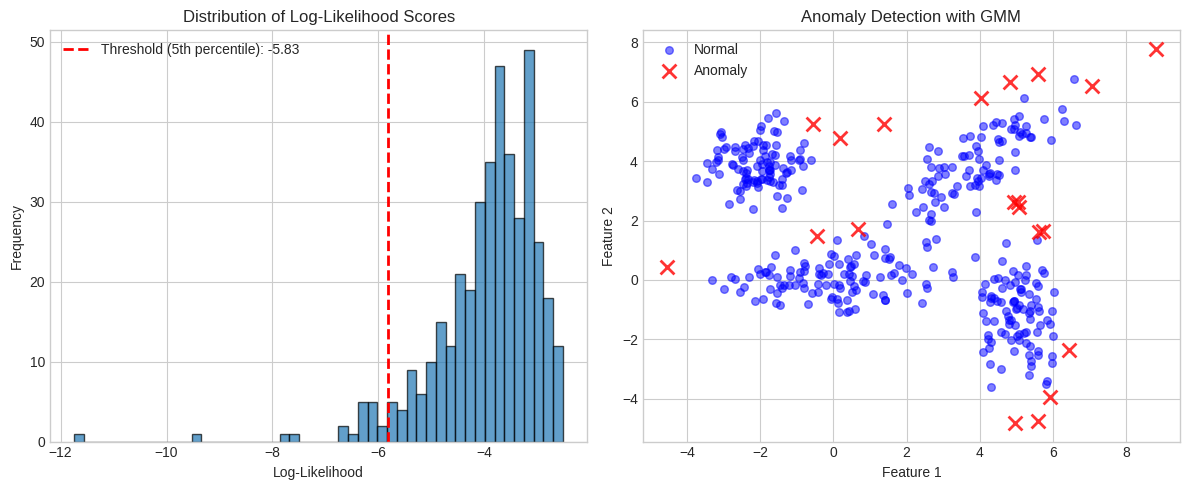

Total samples: 400
Anomalies detected: 20
Anomaly percentage: 5.0%


In [10]:
# Use GMM for anomaly detection based on log-likelihood
log_likelihood = gmm_density.score_samples(X_gmm)

# Define anomalies as points with low likelihood (bottom 5%)
threshold = np.percentile(log_likelihood, 5)
anomalies = log_likelihood < threshold

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(log_likelihood, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2,
            label=f'Threshold (5th percentile): {threshold:.2f}')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequency')
plt.title('Distribution of Log-Likelihood Scores')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_gmm[~anomalies, 0], X_gmm[~anomalies, 1], c='blue',
            alpha=0.5, s=30, label='Normal')
plt.scatter(X_gmm[anomalies, 0], X_gmm[anomalies, 1], c='red',
            alpha=0.8, s=100, marker='x', linewidths=2, label='Anomaly')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Anomaly Detection with GMM')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Total samples: {len(X_gmm)}")
print(f"Anomalies detected: {anomalies.sum()}")
print(f"Anomaly percentage: {100 * anomalies.sum() / len(X_gmm):.1f}%")

## 9. Real Dataset: Iris with GMM

In [11]:
# Load and prepare Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names

# Standardize
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_iris_pca = pca.fit_transform(X_iris_scaled)

print(f"Iris dataset shape: {X_iris.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Iris dataset shape: (150, 4)
Explained variance ratio: [0.72962445 0.22850762]


In [ ]:
# Find optimal number of components using BIC
n_range = range(1, 10)
bic_iris = []
aic_iris = []

for n in n_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_iris_scaled)
    bic_iris.append(gmm.bic(X_iris_scaled))
    aic_iris.append(gmm.aic(X_iris_scaled))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(n_range, bic_iris, 'bo-', label='BIC', linewidth=2, markersize=8)
plt.plot(n_range, aic_iris, 'go-', label='AIC', linewidth=2, markersize=8)
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('Model Selection for Iris Dataset')
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='True K=3')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

optimal_bic_iris = list(n_range)[np.argmin(bic_iris)]
optimal_aic_iris = list(n_range)[np.argmin(aic_iris)]
print(f"Optimal K by BIC: {optimal_bic_iris}")
print(f"Optimal K by AIC: {optimal_aic_iris}")

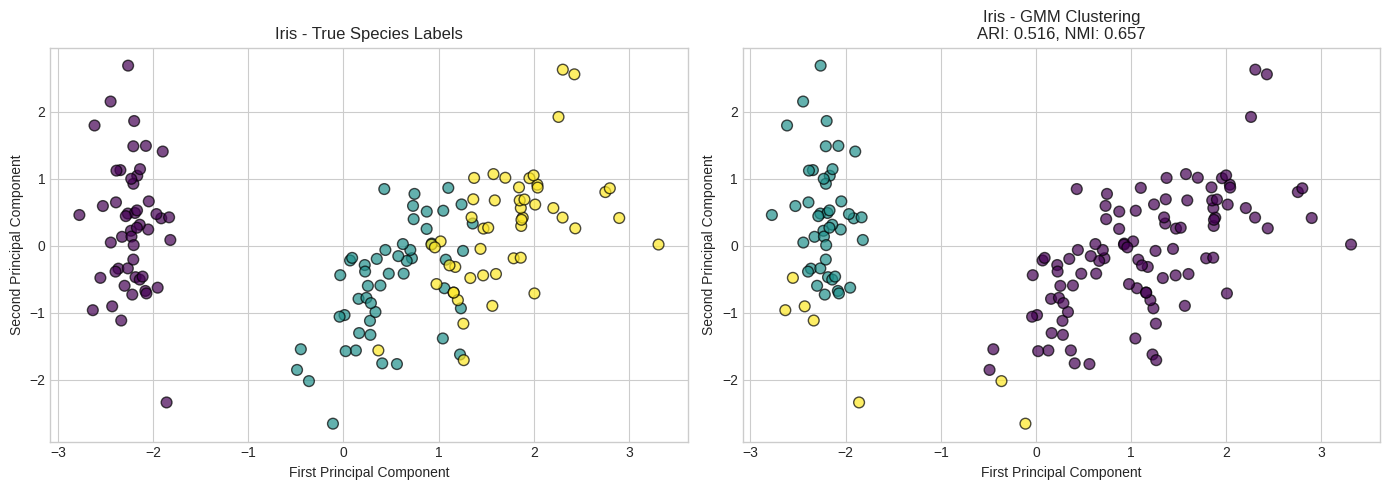


Iris GMM Clustering Metrics:
  Adjusted Rand Index: 0.5165
  Normalized Mutual Info: 0.6571
  Silhouette Score: 0.4751


In [12]:
# Apply GMM with 3 components to Iris
gmm_iris = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
labels_iris = gmm_iris.fit_predict(X_iris_scaled)

# Calculate metrics
ari_iris = adjusted_rand_score(y_iris, labels_iris)
nmi_iris = normalized_mutual_info_score(y_iris, labels_iris)
sil_iris = silhouette_score(X_iris_scaled, labels_iris)

# Visualize in PCA space
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# True labels
scatter1 = axes[0].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=y_iris,
                           cmap='viridis', alpha=0.7, edgecolors='k', s=60)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('Iris - True Species Labels')

# GMM labels
scatter2 = axes[1].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=labels_iris,
                           cmap='viridis', alpha=0.7, edgecolors='k', s=60)
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_title(f'Iris - GMM Clustering\nARI: {ari_iris:.3f}, NMI: {nmi_iris:.3f}')

plt.tight_layout()
plt.show()

print(f"\nIris GMM Clustering Metrics:")
print(f"  Adjusted Rand Index: {ari_iris:.4f}")
print(f"  Normalized Mutual Info: {nmi_iris:.4f}")
print(f"  Silhouette Score: {sil_iris:.4f}")

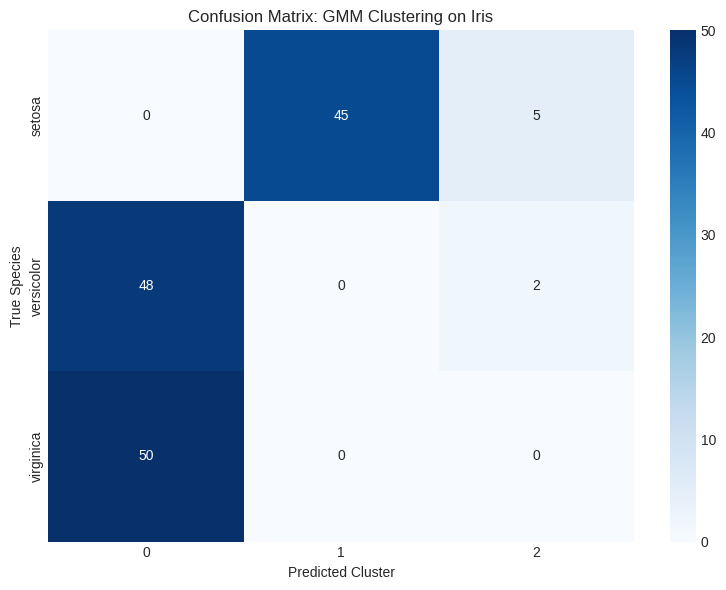


Note: Cluster labels may not align with species labels,
but the clustering structure should match.


In [13]:
# Confusion matrix for GMM predictions
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_iris, labels_iris)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(3), yticklabels=iris.target_names)
plt.xlabel('Predicted Cluster')
plt.ylabel('True Species')
plt.title('Confusion Matrix: GMM Clustering on Iris')
plt.tight_layout()
plt.show()

print("\nNote: Cluster labels may not align with species labels,")
print("but the clustering structure should match.")

## 10. Summary and Conclusions

In [14]:
print("="*70)
print("GAUSSIAN MIXTURE MODELS CLUSTERING - SUMMARY")
print("="*70)

print("\n1. KEY CONCEPTS:")
print("   - GMM models data as mixture of Gaussian distributions")
print("   - Uses Expectation-Maximization (EM) algorithm")
print("   - Provides soft clustering (probability assignments)")

print("\n2. COVARIANCE TYPES:")
print("   - Full: Most flexible, each cluster has own covariance")
print("   - Tied: All clusters share same covariance")
print("   - Diag: Axis-aligned ellipses")
print("   - Spherical: Similar to K-Means")

print("\n3. MODEL SELECTION:")
print("   - BIC (Bayesian Information Criterion): Penalizes complexity more")
print("   - AIC (Akaike Information Criterion): Less penalty")
print("   - Lower values indicate better models")

print("\n4. ADVANTAGES OVER K-MEANS:")
print("   - Handles elliptical clusters (not just spherical)")
print("   - Provides probability estimates")
print("   - Can detect overlapping clusters")
print("   - Useful for density estimation and anomaly detection")

print("\n5. CLUSTERING QUALITY METRICS USED:")
print("   - Silhouette Score")
print("   - Adjusted Rand Index")
print("   - Normalized Mutual Information")
print("   - BIC/AIC for model selection")

print("\n6. APPLICATIONS DEMONSTRATED:")
print("   - Clustering with different covariance structures")
print("   - Soft clustering with uncertainty estimation")
print("   - Density estimation")
print("   - Anomaly detection")

print("\n" + "="*70)

GAUSSIAN MIXTURE MODELS CLUSTERING - SUMMARY

1. KEY CONCEPTS:
   - GMM models data as mixture of Gaussian distributions
   - Uses Expectation-Maximization (EM) algorithm
   - Provides soft clustering (probability assignments)

2. COVARIANCE TYPES:
   - Full: Most flexible, each cluster has own covariance
   - Tied: All clusters share same covariance
   - Diag: Axis-aligned ellipses
   - Spherical: Similar to K-Means

3. MODEL SELECTION:
   - BIC (Bayesian Information Criterion): Penalizes complexity more
   - AIC (Akaike Information Criterion): Less penalty
   - Lower values indicate better models

4. ADVANTAGES OVER K-MEANS:
   - Handles elliptical clusters (not just spherical)
   - Provides probability estimates
   - Can detect overlapping clusters
   - Useful for density estimation and anomaly detection

5. CLUSTERING QUALITY METRICS USED:
   - Silhouette Score
   - Adjusted Rand Index
   - Normalized Mutual Information
   - BIC/AIC for model selection

6. APPLICATIONS DEMONSTRATED